# Consinstently estimating Markov Chains with Noisy Aggregated Data

## Notebook con esperimenti numerici per il seminario di fine corso di Metodi Numerici per le Catene di Markov (versione stazionaria)

In [3]:
# to avoid the pain of restarting the kernel each time
%load_ext autoreload
%autoreload 2

In [4]:
# Import some basic stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.estimators import P_mom_stationary, P_cls_stationary
from utilities.data import generate_random_P, create_observations

In [5]:
# Fissiamo il numero di stati
S = 20

### Experiment n° 1

For the first experiment, we want to examine the behaviour of the MoM and CLS estimators for different values of $T$ and $K$. 

In particular, we want to plot the approximation error against $T\times K$. The approximation error is measured as $\frac{1}{S^2}{\lvert\lvert\hat{P}-P\rvert\rvert}_F^2$

The first thing we do is to generate the true transition matrix $P\in\mathbb{R}^{S\times S}$.

Just like the authors, we choose $S=10$, and each row will have a Dirichlet distribution: $P[i,\colon]\sim\operatorname{Dirichlet}\left(\frac{D}{S}\mathbf{e}\right)$, where $D$ is the precision parameter and $\mathbf{e}$ is the vector of all ones.  

In [6]:
# D=10 (like in the article)
P = generate_random_P(S,'dirichlet',precision=0.5)

Then we need to compute the steady-state vector $\pi$, because in the stationary case we use that as initial distribution.

As seen during the course, there are many ways to do it. Since the size of $P$ is modest, I go for a direct method.

In [8]:
from utilities.num_methods import compute_stationary_LU_GTH

# Initial distribution computation

pi_gth= compute_stationary_LU_GTH(P)
print(f"The norm of pi_gth @ (I-P) = {np.norm(pi_gth@(np.eye(S)-P))}")

# We set the initial distribution
pi_0 = pi_gth

The norm of (I-P.T)@pi is 3.05446410465324e-17


The function `create_observations` generates the data, and automatically adds noise to it, if specified.

Data is generated by drawing $n_t\sim\mathrm{Multinomial}(N,\pi)$ for each $t\in[T]$. We immediately generate $K$ independent observations (noise is added later, independently).

Since the process is (strongly) stationary, each $n_t$ is a multinomial draw from the invariant distribution. That is, contrary to the nonstationary case, the parameter of the multinomial doesn't need to be updated.

**OSS**: Let `n_array, y_array, A = create_observations(...)` 

Then `n_array` and `y_array` are `np.ndarray`s of shape $T\times K\times S$. 

They can be thought as lists of length $T$ in which the item at position $t\in\{0,\dots,T-1\}$ is a $K\times S$ `np.ndarray` that contains the $K$ observations for timestep $t+1$.

Instead, `A` is a $S$ by $S$ `np.ndarray`

We're ready

In [9]:
# choice of the error's distribution parameters
alpha = [1, 0.5, 0.25]
variance = [0, 1, 5]

# ranges
T_range = [10**k for k in range(1,5)]
K_range = [1, 2, 5, 10, 20, 50]

# other parameters
n_reps = 10
N = 100

In [10]:
from itertools import product
from tqdm import tqdm

def error_computation(M:np.ndarray) -> float: 
    return np.linalg.norm(M-P,'fro')/(S**2)

class BreakLoopException(Exception):
    pass


gauss_errors = []
binomial_errors = []

try: 
    prod = product(T_range, K_range, range(0,3))
    for T, K, i in tqdm(prod):
        # Create dictionaries to store data
        gauss_dict_entry = {
            'variance': variance[i],
            'TxK': T*K
        }
        binom_dict_entry = {
            'alpha': alpha[i],
            'TxK': T*K
        }

        # Just like the authors, we repeat each combination 10 times
        for rep in range(n_reps):
            # Generate data
            _, y_array_gauss, A_gauss = create_observations(T=T,
                                                            K=K,
                                                            N=N,
                                                            pi_0=pi_0,
                                                            stationary=True,
                                                            noise_type='gaussian',
                                                            stdev=np.sqrt(variance[i]))
            _, y_array_binom, A_binom = create_observations(T=T,
                                                            K=K,
                                                            N=N,
                                                            pi_0=pi_0,
                                                            stationary=True,
                                                            noise_type = 'binomial',
                                                            alpha=alpha[i]) 
        
            # method of moments estimator
            P_mom_gauss = P_mom_stationary(y_array=y_array_gauss, A=A_gauss, N=N)
            P_mom_binom = P_mom_stationary(y_array=y_array_binom, A=A_binom, N=N)
            # CLS estimator
            P_cls_gauss = P_cls_stationary(y_array = y_array_gauss)
            P_cls_binom = P_cls_stationary(y_array = y_array_binom)

            #if np.isnan(error_computation(P_mom_gauss)):
            #    print("A NaN value has been encountered while computing the error on MoM estimator (Gauss).")
            #    print(f"K = {K}, T = {T}, sigma^2 = {variance[i]}, repetition = {rep+1}")
            #    raise BreakLoopException
                
            #if np.isnan(error_computation(P_mom_binom)):
            #    print("A NaN value has been encountered while computing the error on MoM estimator (Binomial).")
            #    print(f"K = {K}, T = {T}, alpha = {alpha[i]}, repetition = {rep+1}")
            #    raise BreakLoopException

            # compute & store errors
            gauss_dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom_gauss)
            gauss_dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls_gauss)

            binom_dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom_binom)
            binom_dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls_binom)

        # store combination
        gauss_errors.append(gauss_dict_entry)
        binomial_errors.append(binom_dict_entry)

except BreakLoopException:
    print("Emergency brake has been pulled.")
    print("Please investigate.")



0it [00:00, ?it/s]/media/andrea/Windows/Users/marin/Documents/Programmazione/MNCM Lab/MNCM-project/Codice/utilities.py:203: RuntimeWarning: invalid value encountered in divide
  P_mom = ((Sigma_hat/N+np.outer(mu_hat,mu_hat)).T/mu_hat).T
72it [02:26,  2.04s/it]


#### `NaN`s checking, and other checkings in general

As of now, there is a problem with the `NaN`s, and I don't think we'll ever get rid of them.

In [15]:
P_mom_guilty = P_mom_stationary(y_array=y_array_binom, A = A_binom, N=N)

has_nan_or_inf = np.any(np.isnan(P_mom_guilty)) or np.any(np.isinf(P_mom_guilty))
print(f"Matrix contains NaN or infinite values: {has_nan_or_inf}")

if has_nan_or_inf:
    print(f"The matrix has {np.isnan(P_mom_guilty).sum()} NaNs")
    print(f"The matrix has {np.isinf(P_mom_guilty).sum()} Infs")

    # Print coordinates of NaNs
    nan_coords = np.argwhere(np.isnan(P_mom_guilty))
    print("Coordinates of NaNs:")
    for coord in nan_coords:
        print(coord)

Matrix contains NaN or infinite values: True
The matrix has 20 NaNs
The matrix has 0 Infs
Coordinates of NaNs:
[19  0]
[19  1]
[19  2]
[19  3]
[19  4]
[19  5]
[19  6]
[19  7]
[19  8]
[19  9]
[19 10]
[19 11]
[19 12]
[19 13]
[19 14]
[19 15]
[19 16]
[19 17]
[19 18]
[19 19]


In [17]:
y_array_binom.mean(axis=0).squeeze()

array([ 2.6,  0.2,  4.4,  0.3,  9.9,  2.2,  2.8, 15.3,  1.6,  2.3,  0.9,
       14.6, 11.9,  4.1,  0.9,  0.6,  2.1, 13.1, 10.2,  0. ])

In [68]:
m_t_hat_guilty = y_array_gauss.mean(axis=(0,1))
print(m_t_hat_guilty)



[ 5.9  1.1  3.2  3.8  5.7  4.9  4.2  6.1  0.   0.2 10.9 11.7  0.3 12.5
  6.6 12.1  0.5  0.3  9.2  0.8]


Ok the problem is due to a zero division

This is to check if the observations are identical:

In [25]:
check_mom, check_cls = [], []
for dict_entry in gauss_errors:
    lista_mom = np.array([dict_entry[f'error_MoM_{i}'] for i in range(n_reps)])
    lista_cls = np.array([dict_entry[f'error_CLS_{i}'] for i in range(n_reps)])

    check_mom.append(len(np.unique(lista_mom)) == 1)
    check_cls.append(len(np.unique(lista_cls)) == 1)

print(f"Trials with MoM are all equal: {all(check_mom)}")
print(f"Trials with CLS are all equal: {all(check_cls)}")

Trials with MoM are all equal: False
Trials with CLS are all equal: False


---

#### Let's move on

In [11]:
print(f'len(gauss_errors) = {len(gauss_errors)},\t check: {len(T_range)*len(K_range)*len(variance)}')
gauss_errors[0]

len(gauss_errors) = 72,	 check: 72


{'variance': 0,
 'TxK': 10,
 'error_MoM_0': nan,
 'error_CLS_0': 0.04860987366414708,
 'error_MoM_1': nan,
 'error_CLS_1': 603795878828.1321,
 'error_MoM_2': nan,
 'error_CLS_2': 0.04722036399927872,
 'error_MoM_3': nan,
 'error_CLS_3': 0.0988714698109953,
 'error_MoM_4': nan,
 'error_CLS_4': 0.04540566399365221,
 'error_MoM_5': nan,
 'error_CLS_5': 0.05425873506703025,
 'error_MoM_6': nan,
 'error_CLS_6': 0.04853783238939546,
 'error_MoM_7': nan,
 'error_CLS_7': 0.03531674599606016,
 'error_MoM_8': nan,
 'error_CLS_8': 0.03259672521995683,
 'error_MoM_9': nan,
 'error_CLS_9': 0.03254996096534529}

In [12]:
import pandas as pd

# Create dataframes
gauss_df = pd.DataFrame(gauss_errors)
binom_df = pd.DataFrame(binomial_errors)

gauss_df.head()

,variance,TxK,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,0,10,NaN,0.048610,NaN,6.037959e+11,NaN,0.047220,NaN,0.098871,...,NaN,0.054259,NaN,0.048538,NaN,0.035317,NaN,0.032597,NaN,0.032550
1,1,10,0.334151,0.015681,0.266705,1.480926e-02,0.117381,0.014323,0.715372,0.015194,...,4.051469,0.016642,0.677099,0.019612,26.528033,0.015997,6.535415,0.017858,0.679091,0.013832
2,5,10,0.224718,0.013141,0.197000,1.461429e-02,0.509327,0.014822,1.110724,0.014605,...,0.187992,0.012565,0.305071,0.015920,0.777522,0.015642,0.432801,0.013362,4.591493,0.012838
3,0,20,NaN,0.023405,NaN,5.054283e-02,NaN,0.023698,NaN,0.041678,...,NaN,0.105715,NaN,0.036626,NaN,0.034770,NaN,0.034293,NaN,0.080503
4,1,20,0.173985,0.013551,0.319393,1.179861e-02,0.219606,0.013690,0.156737,0.013469,...,0.290395,0.012478,1.321109,0.013926,1.553468,0.013963,0.175744,0.012730,0.215716,0.015429


In [13]:
binom_df.head()

,alpha,TxK,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,1.00,10,NaN,0.039523,NaN,0.061800,NaN,0.048431,NaN,0.022893,...,NaN,0.046157,NaN,0.099971,NaN,0.059189,NaN,0.143503,NaN,0.039382
1,0.50,10,NaN,0.038277,NaN,0.069449,NaN,0.030264,NaN,0.076528,...,NaN,0.067973,NaN,0.083428,NaN,0.065085,NaN,0.338156,NaN,0.090196
2,0.25,10,NaN,0.044546,NaN,0.035997,NaN,0.022366,NaN,0.046924,...,NaN,0.040184,NaN,0.050741,NaN,0.023991,NaN,0.034289,NaN,0.024825
3,1.00,20,NaN,0.101203,NaN,0.753755,NaN,0.129619,NaN,0.029550,...,NaN,0.067564,NaN,0.065007,NaN,0.019138,NaN,0.053495,NaN,0.032936
4,0.50,20,NaN,0.045553,NaN,0.044870,NaN,0.033456,NaN,0.076869,...,NaN,0.071464,NaN,0.074511,NaN,0.103574,NaN,0.236203,NaN,0.060861


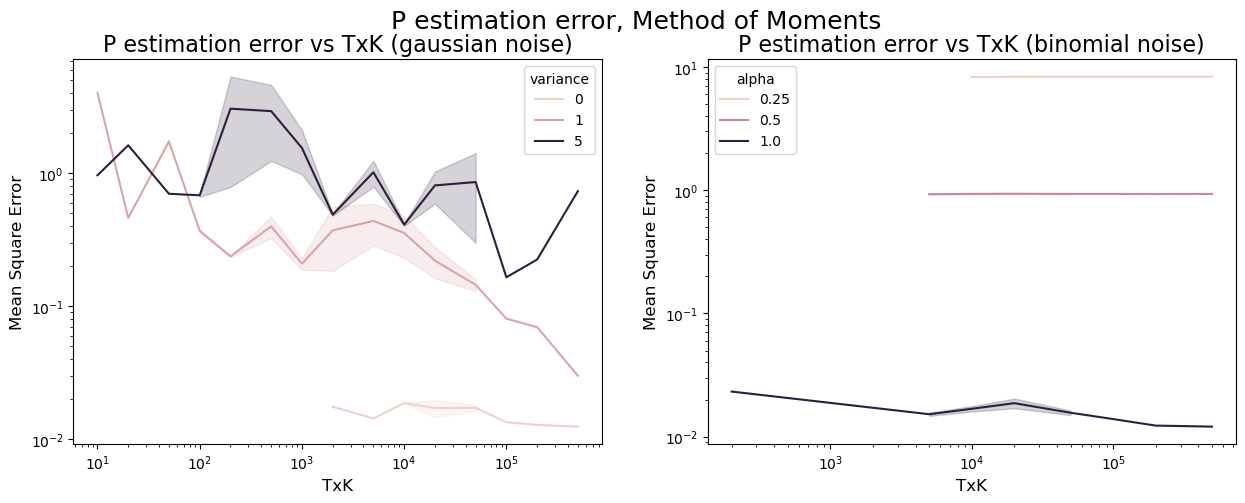

In [14]:
# Plot results

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    y = data_che_uso[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    hue_val = 'variance' if noise_type == 'gaussian' else 'alpha'
    sns.lineplot(data=data_che_uso, x='TxK', y=y, hue=hue_val, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)

fig.suptitle('P estimation error, Method of Moments', fontsize=18)
plt.show()

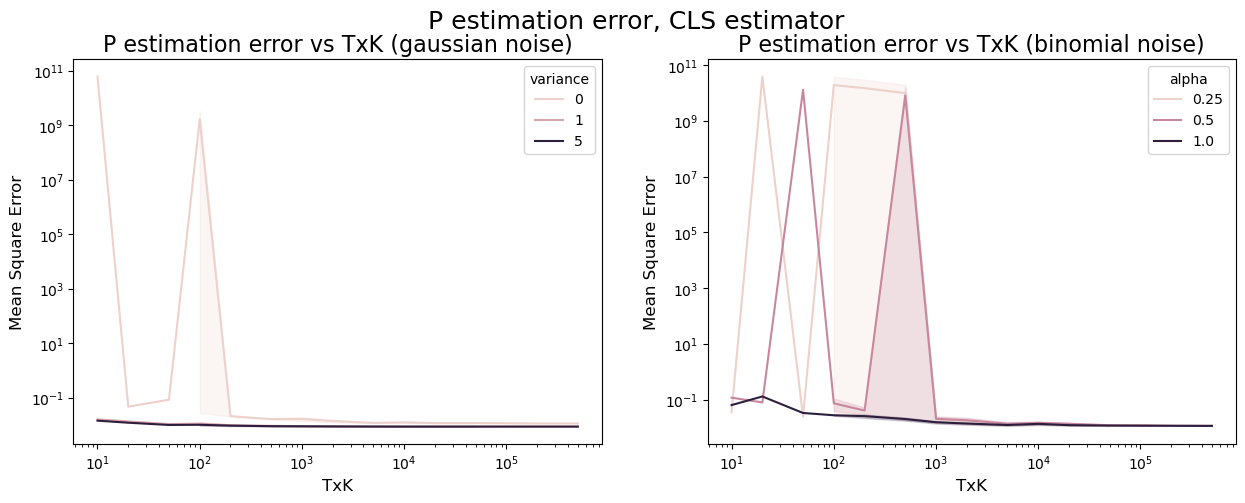

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    y = data_che_uso[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    hue_val = 'variance' if noise_type == 'gaussian' else 'alpha'
    sns.lineplot(data=data_che_uso, x='TxK', y=y, hue=hue_val, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)

fig.suptitle('P estimation error, CLS estimator', fontsize=18)
plt.show()

### Experiment n° 2

For the second experiment, we assess the impact of the population size $N$.

In [20]:
N_range = [10**k for k in range(0,5)]
T = 10**5
K = 20

n_reps = 10

In [21]:
N_errors = []

for N in tqdm(N_range):
    dict_entry = {'N':N}

    for rep in range(n_reps):
        n_array, _, _ = create_observations(T=T,N=N,K=K,pi_0=pi_0,stationary=True)

        P_mom = P_mom_stationary(y_array = n_array, A = np.eye(S), N=N)
        P_cls = P_cls_stationary(y_array = n_array)

        dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom)
        dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls)

    N_errors.append(dict_entry)

  0%|          | 0/5 [00:00<?, ?it/s]/media/andrea/Windows/Users/marin/Documents/Programmazione/MNCM Lab/MNCM-project/Codice/utilities.py:203: RuntimeWarning: invalid value encountered in divide
  P_mom = ((Sigma_hat/N+np.outer(mu_hat,mu_hat)).T/mu_hat).T
100%|██████████| 5/5 [02:20<00:00, 28.09s/it]


In [22]:
N_df = pd.DataFrame(N_errors)
N_df.head()

,N,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,error_CLS_3,error_MoM_4,...,error_MoM_5,error_CLS_5,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9
0,1,NaN,0.011215,NaN,0.011270,NaN,0.011210,NaN,0.011217,NaN,...,0.011534,0.011272,0.011660,0.011318,NaN,0.011219,NaN,0.011226,0.011543,0.011217
1,10,0.011471,0.011346,0.011427,0.011314,0.011755,0.011323,0.011693,0.011400,0.011610,...,0.011455,0.011284,0.011798,0.011323,NaN,0.011235,0.011395,0.011239,0.011759,0.011295
2,100,0.011696,0.011816,0.011470,0.011441,0.011716,0.011646,0.012188,0.012158,0.011744,...,0.011396,0.011426,0.011433,0.011421,0.011442,0.011415,0.011519,0.011533,0.011562,0.011429
3,1000,0.011469,0.011486,0.011451,0.011503,0.011420,0.011367,0.011609,0.011624,0.012069,...,0.011584,0.011570,0.011621,0.011645,0.011472,0.011465,0.011458,0.011469,0.011760,0.011749
4,10000,0.011425,0.011426,0.011512,0.011515,0.011287,0.011288,0.011379,0.011370,0.011704,...,0.011718,0.011736,0.011392,0.011406,0.011583,0.011576,0.011546,0.011569,0.011387,0.011394


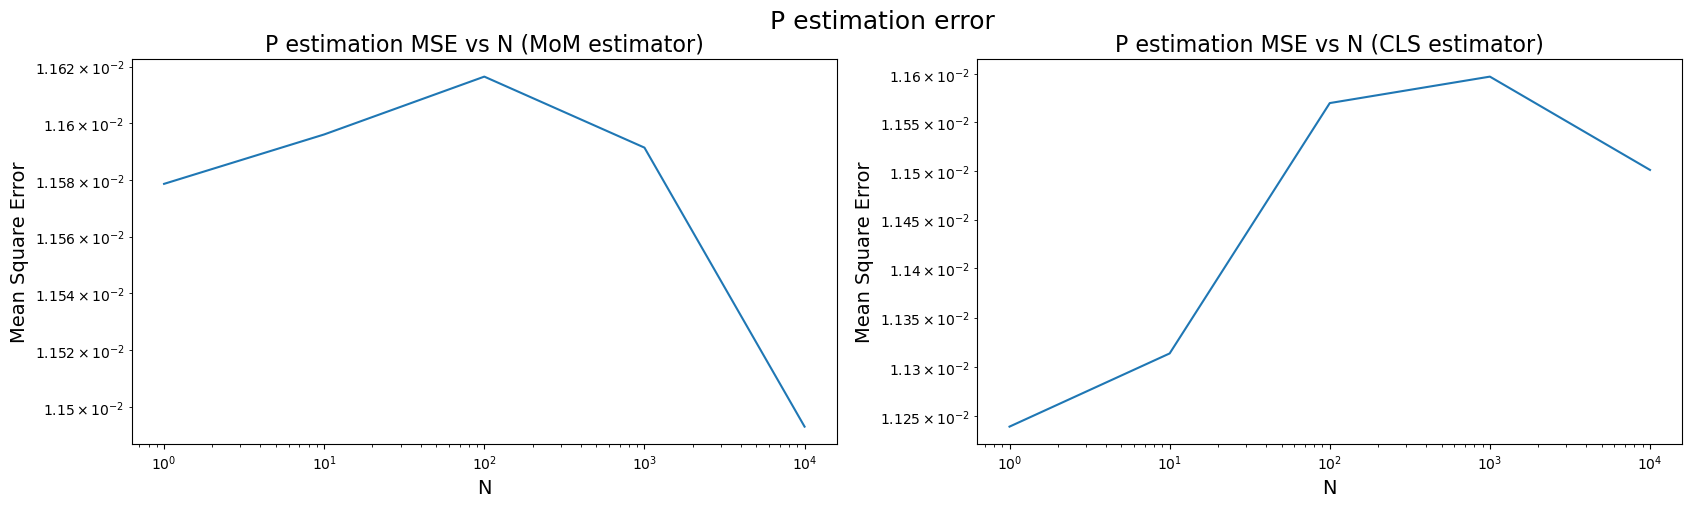

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

for i, estimator in enumerate(['MoM', 'CLS']):
    y = N_df[[f'error_{estimator}_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    sns.lineplot(data=N_df, x='N', y=y, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('N', fontsize=14)
    ax[i].set_ylabel('Mean Square Error', fontsize=14)
    ax[i].set_title(f'P estimation MSE vs N ({estimator} estimator)', fontsize=16)

fig.suptitle('P estimation error', fontsize=18)
plt.show()

We can see that the error has the same order of magnitude, independently from $N$. This is in accordance with what's been found by the authors.

### Experiment n° 3

For the third experiment we compare our models against a naive baseline.